# Введение в нейронные сети

## Урок 6. Сегментация

### Практическое задание

Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Напишите в комментариях к уроку, какого результата вы добились от нейросети, что помогло улучшить её точность?

### Решение

#### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
from scipy import io
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU

from tensorflow.keras.datasets import imdb

#### Глобальные настройки проекта

In [2]:
# Случайное зерно.
GLOBAL__RANDOM_STATE = 0

# Путь к изображениям и маскам.
PATH_DATASET = '\\clothing-co-parsing-master\photos\\'
PATH_MASKS = '\\clothing-co-parsing-master\\annotations\\pixel-level\\'

#### Загрузка и подготовка датасета clothing-co-parsing-master

In [3]:
# Обработка изображений: нормализация и изменение размера.
def preprocess_image(image):
    image = tf.cast(image, tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (128, 128))
    return image 
     
# Обработка масок: нормализация и изменение размера.
def preprocess_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (128, 128))
    mask = tf.cast(mask != 0, tf.uint8)
    return mask  

In [4]:
%%time

images = []
masks = []

# Загрузка изображений и масок.
for mask_filename in os.listdir(os.getcwd() + PATH_MASKS):
    image_filename = mask_filename[:-4] + '.jpg'
    image = img_to_array(load_img(os.getcwd() + PATH_DATASET + image_filename))
    images.append(preprocess_image(image))

    mask_file = io.loadmat(os.getcwd() + PATH_MASKS + mask_filename)
    mask = tf.convert_to_tensor(mask_file['groundtruth']) 
    masks.append(preprocess_mask(mask))

Wall time: 9.09 s


In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=0)

X_train = tf.data.Dataset.from_tensor_slices(X_train)
X_test = tf.data.Dataset.from_tensor_slices(X_test)
y_train = tf.data.Dataset.from_tensor_slices(y_train)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

train = tf.data.Dataset.zip((X_train, y_train))
test = tf.data.Dataset.zip((X_test, y_test)) 

In [6]:
# Функции для аугментации:
# - яркость;
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

# - оттенок;
def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

# - отзеркаливание по горизонтали.
def flip_horisontal(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

In [7]:
%%time

# Последовательно применяем аугментации.
train = train.concatenate(train.map(brightness))
train = train.concatenate(train.map(hue))
train = train.concatenate(train.map(flip_horisontal))

Wall time: 77.8 ms


#### Функции для визуализации

In [19]:
def display(display_list):
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(model, dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

#### Построение нейросети

In [8]:
# Параметры нейросети.
tf.random.set_seed(0)
BATCH_SIZE = 32
BUFFER_SIZE = 500
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train = train.prefetch(buffer_size=BUFFER_SIZE)
test = test.batch(BATCH_SIZE)

In [9]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [10]:
up_stack = [
    tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same', use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same', use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same', use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', use_bias=False, activation='relu')
]

In [11]:
def resolution_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
#     x = inputs

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [12]:
%%time

OUTPUT_CHANNELS = 3

model = resolution_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Wall time: 271 ms


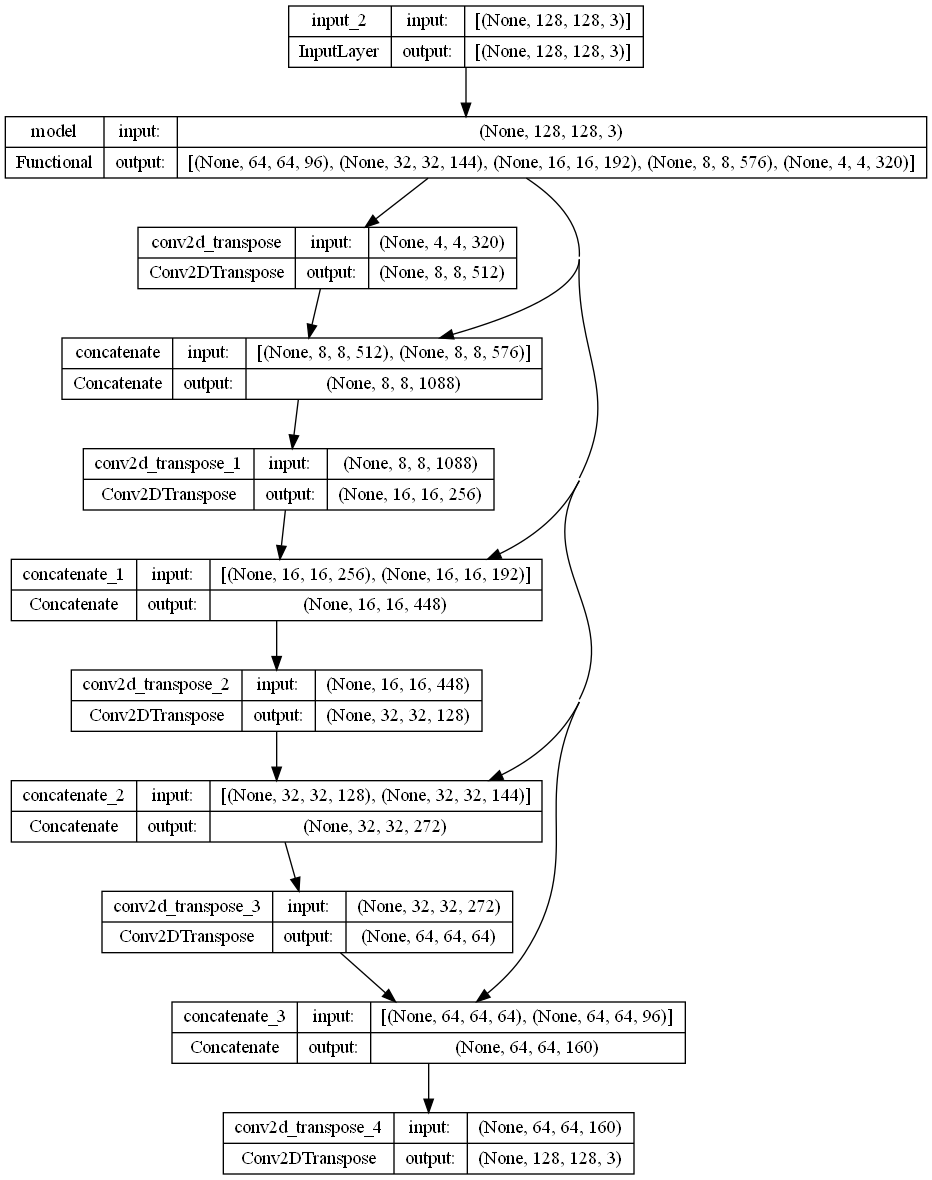

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [22]:
# sample_image, sample_mask = next(iter(train.take(1)))
# sample_image, sample_mask = X_train[0], y_train[0]
# show_predictions(model)

TypeError: 'TensorSliceDataset' object is not subscriptable

#### Обучение

In [18]:
%%time

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions(model)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

EPOCHS = 10 # увеличьте при необходимости

model_history = model.fit(train,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=test,
                          callbacks=[DisplayCallback()])

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

Epoch 1/10
199/201 [============================>.] - ETA: 0s - loss: 0.1739 - accuracy: 0.9273

KeyboardInterrupt: 

Work in progress.